Loaded ONE long trajectory: T=152500, d=3
RNN | K=10 | Epoch 01 | train_MSE=0.781513 | val_MSE=0.596683 | best=0.596683
RNN | K=10 | Epoch 02 | train_MSE=0.275648 | val_MSE=0.129494 | best=0.129494
RNN | K=10 | Epoch 03 | train_MSE=0.088196 | val_MSE=0.055689 | best=0.055689
RNN | K=10 | Epoch 04 | train_MSE=0.047971 | val_MSE=0.026849 | best=0.026849
RNN | K=10 | Epoch 05 | train_MSE=0.030258 | val_MSE=0.013713 | best=0.013713
RNN | K=10 | Epoch 06 | train_MSE=0.021729 | val_MSE=0.007384 | best=0.007384
RNN | K=10 | Epoch 07 | train_MSE=0.017828 | val_MSE=0.005079 | best=0.005079
RNN | K=10 | Epoch 08 | train_MSE=0.015971 | val_MSE=0.003620 | best=0.003620
RNN | K=10 | Epoch 09 | train_MSE=0.014483 | val_MSE=0.002895 | best=0.002895
RNN | K=10 | Epoch 10 | train_MSE=0.013705 | val_MSE=0.002526 | best=0.002526
RNN | K=10 | Epoch 11 | train_MSE=0.013089 | val_MSE=0.002427 | best=0.002427
RNN | K=10 | Epoch 12 | train_MSE=0.012565 | val_MSE=0.001926 | best=0.001926
RNN | K=10 | Epoch 13 

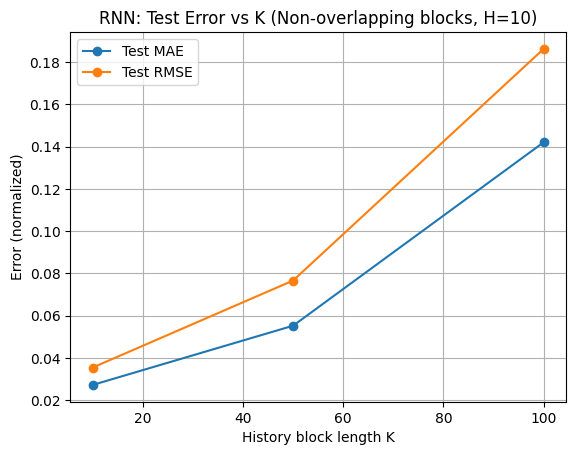

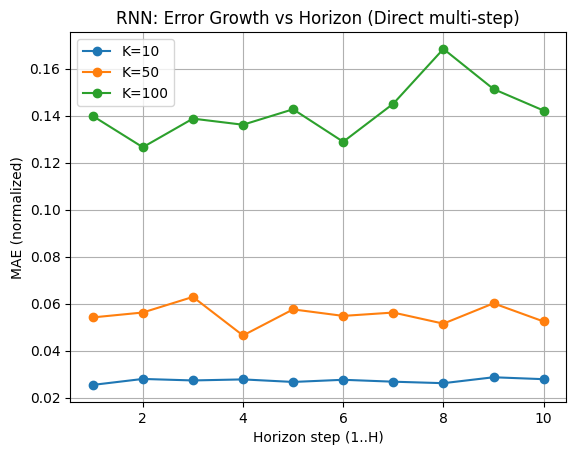

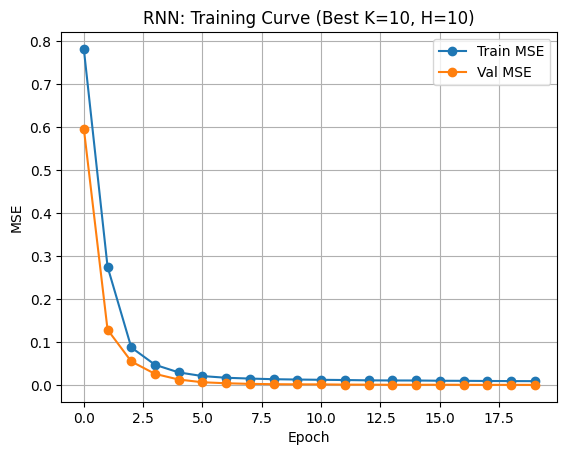

In [1]:
import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

CSV_PATH = "/kaggle/input/robotic-arm-dataset-multiple-trajectories/robotic_arm_dataset_multiple_trajectories.csv"
FEATURE_COLS = ["Axis_0_Angle", "Axis_1_Angle", "Axis_2_Angle"]

# We assume the whole dataset is ONE long trajectory.
K_LIST = [10, 50, 100]         # history block lengths to try
H = 10                         # predict next H steps (block)

TRAIN_RATIO = 0.70    # time-based split on blocks: earliest blocks for train
VAL_RATIO = 0.15      # next blocks for val, rest for test

BATCH_SIZE = 256
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4

HIDDEN = 64
LAYERS = 1
DROPOUT = 0.1

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# =========================
# 1) Reproducibility
# =========================
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

def overall_mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred)))

def overall_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def per_step_mae(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    # (N, H, d) -> (H,)
    return np.mean(np.abs(y_true - y_pred), axis=(0, 2))

# =========================
# 2) Data Loading & Prep
# =========================
df = pd.read_csv(CSV_PATH)
X_raw = df[FEATURE_COLS].to_numpy(dtype=np.float32)  # (T, d)
T, d = X_raw.shape
print(f"Loaded ONE long trajectory: T={T}, d={d}")

# Normalize using TRAIN portion of time.
t_train_end = int(TRAIN_RATIO * T)
eps = 1e-6
mu = X_raw[:t_train_end].mean(axis=0, keepdims=True)
std = X_raw[:t_train_end].std(axis=0, keepdims=True)
X = (X_raw - mu) / (std + eps)  # normalized long trajectory

def compute_num_blocks(T, K, H):
    block_len = K + H
    return (T - block_len) // block_len + 1 if T >= block_len else 0

class BlockDataset(Dataset):
    def __init__(self, X: np.ndarray, K: int, H: int, block_ids: np.ndarray):
        self.X = X
        self.K = K
        self.H = H
        self.block_len = K + H
        self.block_ids = block_ids.astype(np.int64)

    def __len__(self):
        return len(self.block_ids)

    def __getitem__(self, idx):
        bid = int(self.block_ids[idx])
        s = bid * self.block_len
        x = self.X[s : s + self.K]                    # (K,d)
        y = self.X[s + self.K : s + self.K + self.H]  # (H,d)
        return torch.from_numpy(x), torch.from_numpy(y)

# =========================
# 3) Vanilla RNN Model
# =========================
class RNNDirect(nn.Module):
    def __init__(self, d: int, hidden: int, layers: int, H: int, dropout: float):
        super().__init__()
        self.H = H
        self.d = d
        self.rnn = nn.RNN(
            input_size=d,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.drop = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.fc = nn.Linear(hidden, H * d)

    def forward(self, x):
        # x: (B,K,d)
        out, _ = self.rnn(x)
        last = out[:, -1, :]
        last = self.drop(last)
        y = self.fc(last)               # (B, H*d)
        return y.view(-1, self.H, self.d)

# =========================
# 4) Training & Evaluation
# =========================
def eval_mse(model, loader):
    model.eval()
    loss_fn = nn.MSELoss()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            pred = model(xb)
            losses.append(loss_fn(pred, yb).item())
    return float(np.mean(losses)) if losses else float("nan")

def collect_predictions(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            pred = model(xb.to(DEVICE)).cpu().numpy()
            preds.append(pred)
            trues.append(yb.numpy())
    return np.concatenate(trues, axis=0), np.concatenate(preds, axis=0)

results = []
histories = {}
step_curves = {}

for K in K_LIST:
    n_blocks = compute_num_blocks(T, K, H)
    if n_blocks <= 5:
        print(f"[SKIP] K={K}: too few blocks ({n_blocks}).")
        continue

    n_train = int(TRAIN_RATIO * n_blocks)
    n_val = int(VAL_RATIO * n_blocks)
    n_test = n_blocks - n_train - n_val

    train_block_ids = np.arange(0, n_train)
    val_block_ids = np.arange(n_train, n_train + n_val)
    test_block_ids = np.arange(n_train + n_val, n_blocks)

    train_ds = BlockDataset(X, K, H, train_block_ids)
    val_ds   = BlockDataset(X, K, H, val_block_ids)
    test_ds  = BlockDataset(X, K, H, test_block_ids)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize RNNDirect instead of LSTMDirect
    model = RNNDirect(d=d, hidden=HIDDEN, layers=LAYERS, H=H, dropout=DROPOUT).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    train_mse_hist, val_mse_hist = [], []

    for ep in range(1, EPOCHS + 1):
        model.train()
        batch_losses = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())

        train_mse = float(np.mean(batch_losses)) if batch_losses else float("nan")
        val_mse = eval_mse(model, val_loader)
        train_mse_hist.append(train_mse)
        val_mse_hist.append(val_mse)

        if val_mse < best_val:
            best_val = val_mse
            best_state = {kk: vv.detach().cpu().clone() for kk, vv in model.state_dict().items()}

        print(f"RNN | K={K:2d} | Epoch {ep:02d} | train_MSE={train_mse:.6f} | val_MSE={val_mse:.6f} | best={best_val:.6f}")

    model.load_state_dict(best_state)

    y_true, y_pred = collect_predictions(model, test_loader)
    test_mae = overall_mae(y_true, y_pred)
    test_rmse = overall_rmse(y_true, y_pred)
    curve = per_step_mae(y_true, y_pred)  # (H,)

    results.append({
        "K": K,
        "H": H,
        "Blocks_total": n_blocks,
        "Blocks_train": len(train_ds),
        "Blocks_val": len(val_ds),
        "Blocks_test": len(test_ds),
        "Best_Val_MSE": best_val,
        "Test_MAE": test_mae,
        "Test_RMSE": test_rmse,
    })
    histories[K] = {"train_mse": train_mse_hist, "val_mse": val_mse_hist}
    step_curves[K] = curve

results_df = pd.DataFrame(results).sort_values("K").reset_index(drop=True)
print("\n===== Vanilla RNN Summary (non-overlap blocks) =====")
print(results_df)

# =========================
# 5) Plotting
# =========================
if len(results_df) > 0:
    # (A) Test MAE/RMSE vs K
    plt.figure()
    plt.plot(results_df["K"], results_df["Test_MAE"], marker="o", label="Test MAE")
    plt.plot(results_df["K"], results_df["Test_RMSE"], marker="o", label="Test RMSE")
    plt.xlabel("History block length K")
    plt.ylabel("Error (normalized)")
    plt.title(f"RNN: Test Error vs K (Non-overlapping blocks, H={H})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # (B) Error growth vs horizon step (MAE per step) for each K
    plt.figure()
    steps = np.arange(1, H + 1)
    for K in results_df["K"].tolist():
        plt.plot(steps, step_curves[K], marker="o", label=f"K={K}")
    plt.xlabel("Horizon step (1..H)")
    plt.ylabel("MAE (normalized)")
    plt.title(f"RNN: Error Growth vs Horizon (Direct multi-step)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # (C) Training curve for best K by Test_MAE
    best_k = int(results_df.loc[results_df["Test_MAE"].idxmin(), "K"])
    plt.figure()
    plt.plot(histories[best_k]["train_mse"], marker="o", label="Train MSE")
    plt.plot(histories[best_k]["val_mse"], marker="o", label="Val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(f"RNN: Training Curve (Best K={best_k}, H={H})")
    plt.legend()
    plt.grid(True)
    plt.show()